In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from saf_sinasc.models import ModelEvaluator
from saf_sinasc.config import EVALUATORS_PATH

%matplotlib inline

In [15]:
names = ["DT", "RF", "XGB"]

# dt = ModelEvaluator.load(EVALUATORS_PATH/"1000"/f"model_evaluator_{names[0]}.joblib")
dt, rf, xgb = [ModelEvaluator.load(EVALUATORS_PATH/"1000"/f"model_evaluator_{name}.joblib") for name in names ]

evaluators = [dt, rf, xgb]

/home/gabriel/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


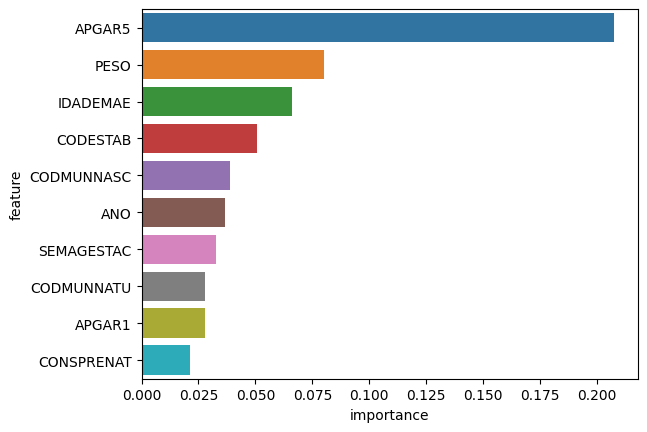

In [31]:
# Seaborn

# agora com colunas

# get feature importancesa

import os

NUM_OF_FEATURES_TO_DISPLAY = 10

def plot_aggregated_feature_importances(evaluator, num_of_features_to_display = NUM_OF_FEATURES_TO_DISPLAY):
    # Take the mean of the list of feature importance per sample
    fi_mean =  pd.DataFrame(evaluator.feature_importances).mean()

    # create a DataFrame with feature importances
    df_importances = (
        pd.DataFrame({'feature': evaluator.training_columns, 'importance': fi_mean})
        .sort_values('importance', ascending=False)
        .iloc[:num_of_features_to_display]
    )

    # plot feature importances
    sns.barplot(x='importance', y='feature', data=df_importances)
    
    
#     os.makedirs(os.path.dirname("teste.png"), exist_ok=True)
    plt.savefig("teste.png")

#     plt.show()
    
plot_aggregated_feature_importances(dt)

# Rascunhos de modelo

In [ ]:
# Preciso de uns modelo pra plottar and stuff

from saf_sinasc.models import default_run_models

bla = default_run_models(num_samples=2)

In [ ]:
demo = bla[0].model
demo

In [ ]:
demo.feature_importances_

In [ ]:
bla[0].training_columns

In [ ]:
import matplotlib.pyplot as plt

# # get feature importances
importances = demo.feature_importances_
# feature_names = X.columns.tolist()

# # sort feature importances in descending order
sorted_idx = importances.argsort()[::-1]
    # # ^ oqq isso faz???

# # VERIFICAR COMO CONFIG DEPOIS
NUM_OF_FEATURES_TO_DISPLAY = 10

    
sorted_importances = importances[sorted_idx][:NUM_OF_FEATURES_TO_DISPLAY]
# sorted_feature_names = [feature_names[i] for i in sorted_idx]

type(importances)

# # plot feature importances
plt.barh(range(NUM_OF_FEATURES_TO_DISPLAY), sorted_importances)
# plt.yticks(range(X.shape[1]), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
# Seaborn

# agora com colunas

# get feature importancesa

def aux(feature_importances):
    importances = feature_importances
    feature_names = bla[0].training_columns.tolist()

    # create a DataFrame with feature importances
    df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # sort feature importances in descending order
    df_importances = df_importances.sort_values('importance', ascending=False)

    df_importances = df_importances.iloc[:10]

    # plot feature importances
    sns.barplot(x='importance', y='feature', data=df_importances)
    plt.show()
    
aux(bla[0].model.feature_importances_)

# Os plot de roc auc que nao deram certo i guess

In [ ]:
bla[0].results

In [ ]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# # generate some random data
# X, y = make_classification(n_samples=1000, random_state=42)

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # create a decision tree classifier
# clf = DecisionTreeClassifier(random_state=42)

# # train the classifiebr on the training set
# clf.fit(X_train, y_train)

# X e y soh tem la pra tras.

# predict probabilities on the test set
y_proba = clf.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# plot the ROC curve using RocCurveDisplay
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree')
roc_display.plot()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = bla[0].model

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()